Loading data...
  Loaded g6sulfur
  Loaded ssp245

Loading land mask...

Calculating seasonal RMSE...


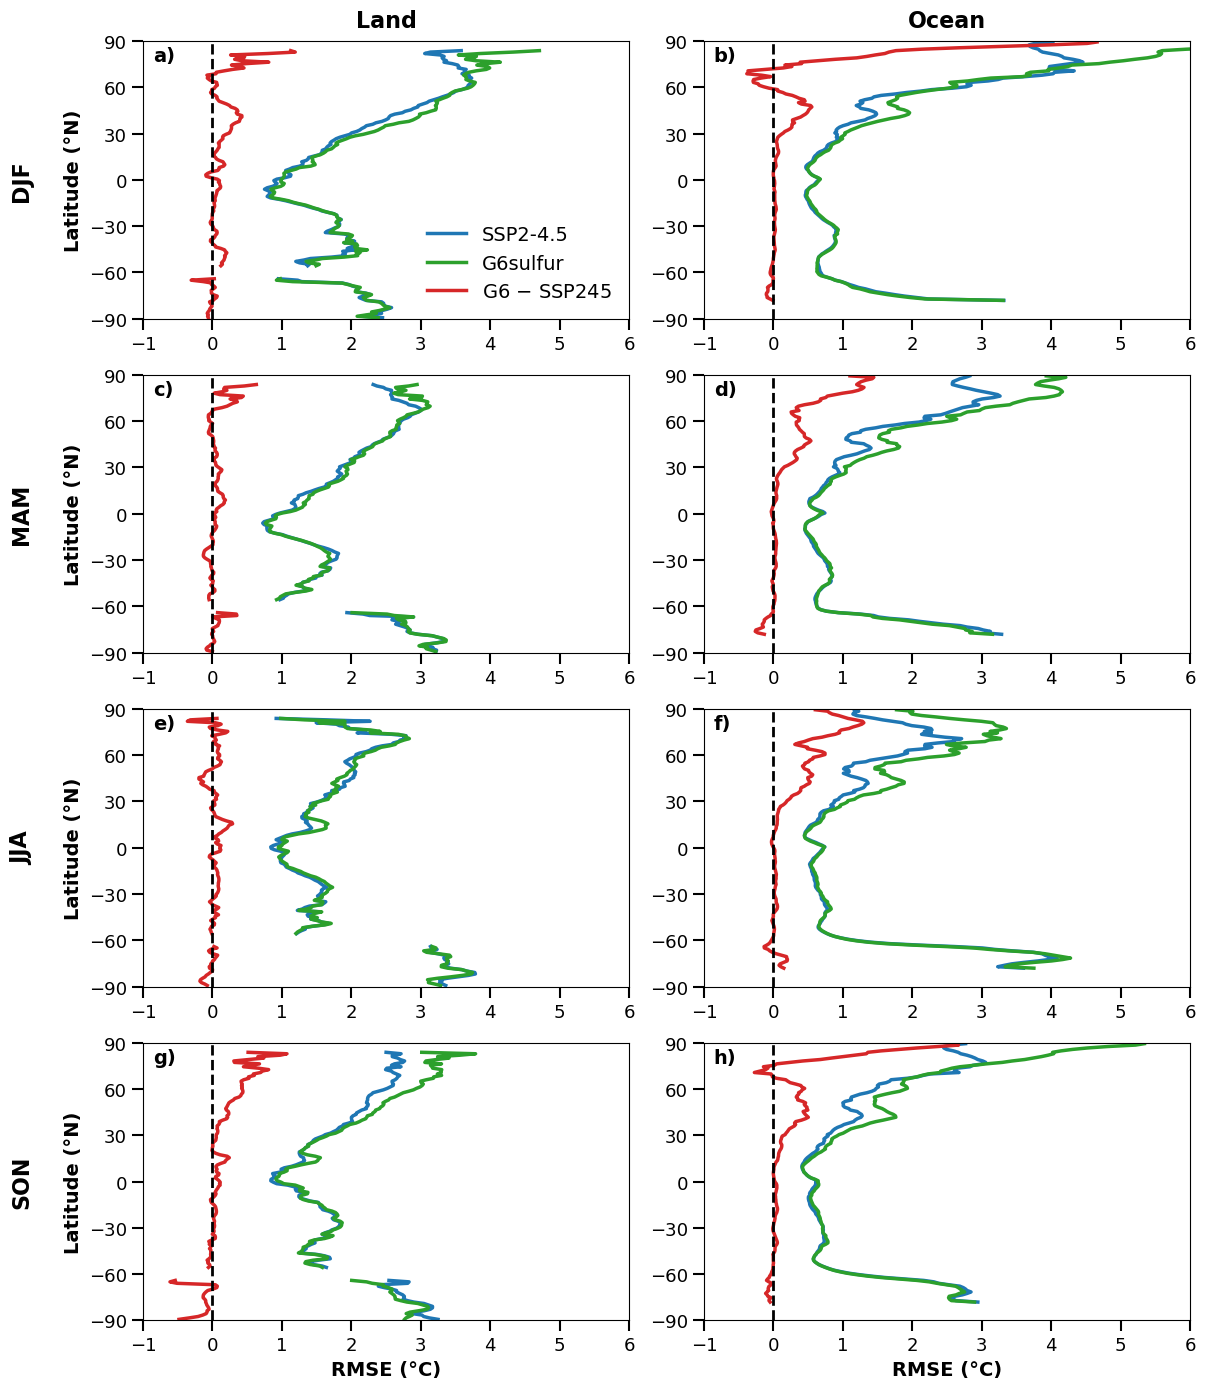

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# ----------------------------
# Configuration
# ----------------------------
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
data_dir = Path("../data")

var_name = 'tas'
scenarios = ['g6sulfur', 'ssp245']
model_key = 'pred_grid'

# Seasons
seasons = {
    'DJF': [12, 1, 2],
    'MAM': [3, 4, 5],
    'JJA': [6, 7, 8],
    'SON': [9, 10, 11]
}

season_labels = ['DJF', 'MAM', 'JJA', 'SON']

# ----------------------------
# Helper Functions
# ----------------------------
def load_land_mask(mask_file):
    """Load land-sea mask."""
    ds_mask = xr.open_dataset(mask_file)
    land_mask = ds_mask['sftlf'].values > 50.0
    ds_mask.close()
    return land_mask

def calculate_seasonal_rmse(pred_data, truth_data, time, season_months):
    """
    Calculate seasonal RMSE.
    
    Args:
        pred_data: (time, lat, lon) array
        truth_data: (time, lat, lon) array
        time: time coordinate
        season_months: list of months for the season
    
    Returns:
        seasonal_rmse: (lat, lon) array
    """
    months = time.dt.month.values
    season_mask = np.isin(months, season_months)
    
    squared_error = (pred_data - truth_data) ** 2
    seasonal_squared_error = squared_error[season_mask]
    seasonal_rmse = np.sqrt(np.mean(seasonal_squared_error, axis=0))
    
    return seasonal_rmse

def compute_zonal_mean_rmse(rmse_2d, land_mask, mask_type):
    """
    Compute zonal mean (longitude average) for land or ocean.
    
    Args:
        rmse_2d: (lat, lon) RMSE array
        land_mask: (lat, lon) boolean mask (True=land)
        mask_type: 'land' or 'ocean'
    
    Returns:
        zonal_mean: (lat,) array
    """
    if mask_type == 'land':
        masked_rmse = np.where(land_mask, rmse_2d, np.nan)
    elif mask_type == 'ocean':
        masked_rmse = np.where(~land_mask, rmse_2d, np.nan)
    else:
        masked_rmse = rmse_2d
    
    # Take mean over longitude (ignoring NaN)
    zonal_mean = np.nanmean(masked_rmse, axis=1)
    
    return zonal_mean

# ----------------------------
# Load data
# ----------------------------
print("Loading data...")
data = {}

for scenario in scenarios:
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds = xr.open_dataset(residual_file)
    
    data[scenario] = {
        'pred': ds[model_key].values,
        'truth': ds['groundtruth'].values,
        'time': ds.time,
        'lat': ds.lat.values,
        'lon': ds.lon.values
    }
    print(f"  Loaded {scenario}")

# Get coordinates
lat = data['g6sulfur']['lat']
lon = data['g6sulfur']['lon']

# Load land mask
print("\nLoading land mask...")
land_mask_file = data_dir / "sftlf_fx_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn.nc"
land_mask = load_land_mask(land_mask_file)

# ----------------------------
# Calculate seasonal RMSE and zonal means
# ----------------------------
print("\nCalculating seasonal RMSE...")
zonal_results = {
    'land': {},
    'ocean': {}
}

for mask_type in ['land', 'ocean']:
    for season_name, season_months in seasons.items():
        zonal_results[mask_type][season_name] = {}
        
        for scenario in scenarios:
            # Calculate seasonal RMSE (2D)
            rmse_2d = calculate_seasonal_rmse(
                data[scenario]['pred'],
                data[scenario]['truth'],
                data[scenario]['time'],
                season_months
            )
            
            # Compute zonal mean
            zonal_mean = compute_zonal_mean_rmse(rmse_2d, land_mask, mask_type)
            zonal_results[mask_type][season_name][scenario] = zonal_mean
        
        # Compute delta-RMSE
        delta_rmse = (zonal_results[mask_type][season_name]['g6sulfur'] - 
                     zonal_results[mask_type][season_name]['ssp245'])
        zonal_results[mask_type][season_name]['delta'] = delta_rmse

# ----------------------------
# Create 4x2 subplot figure
# ----------------------------
fig, axes = plt.subplots(4, 2, figsize=(12, 14))

colors = {
    'ssp245': '#1f77b4',    # Blue
    'g6sulfur': '#2ca02c',  # Green
    'delta': '#d62728'      # Red
}

mask_labels = ['Land', 'Ocean']

for row_idx, season_name in enumerate(season_labels):
    for col_idx, mask_type in enumerate(['land', 'ocean']):
        ax = axes[row_idx, col_idx]
        
        # Get data
        rmse_ssp245 = zonal_results[mask_type][season_name]['ssp245']
        rmse_g6 = zonal_results[mask_type][season_name]['g6sulfur']
        delta_rmse = zonal_results[mask_type][season_name]['delta']
        
        # Plot SSP2-4.5 (blue, no markers)
        ax.plot(rmse_ssp245, lat, color=colors['ssp245'], 
                linewidth=2.5, label='SSP2-4.5')
        
        # Plot G6sulfur (green, no markers)
        ax.plot(rmse_g6, lat, color=colors['g6sulfur'], 
                linewidth=2.5, label='G6sulfur')
        
        # Plot delta-RMSE (red, no markers)
        ax.plot(delta_rmse, lat, color=colors['delta'], 
                linewidth=2.5, label=r'G6 $-$ SSP245')
        
        # Add thick dashed black line at x=0
        ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=1)
        
        # Formatting
        ax.set_ylim(-90, 90)
        ax.set_yticks(np.arange(-90, 91, 30))
        ax.set_xlim(-1, 6)  # Adjusted for RMSE (always positive, different scale)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=13, 
                      length=8, width=1.5)
        
        # Labels
        if row_idx == 3:  # Bottom row
            ax.set_xlabel('RMSE (°C)', fontsize=14, fontweight='bold')
        
        if col_idx == 0:  # Left column
            ax.set_ylabel('Latitude (°N)', fontsize=14, fontweight='bold')
        
        # Title for top row
        if row_idx == 0:
            ax.set_title(mask_labels[col_idx], fontsize=16, fontweight='bold', pad=10)
        
        # Season label on left side
        if col_idx == 0:
            ax.text(-0.25, 0.5, season_name, 
                   transform=ax.transAxes,
                   fontsize=16, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Legend (only for top-left panel, no frame, lower right location)
        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=14, loc='lower right', frameon=False)
        
        # Add panel label
        panel_label = chr(97 + row_idx * 2 + col_idx) + ')'
        ax.text(0.02, 0.98, panel_label, 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top')

plt.tight_layout()
output_file = figures_dir / "g6sulfur_ssp245_rmse_lat_profile.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()